## 0. Import Required Packages

In [1]:
#a super learner model for regression
from math import sqrt
from numpy import vstack
from numpy import asarray
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from numpy import hstack
from numpy import array
import pygeostat as gs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\gamze\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Grid Definition  and Dataset Description

In [4]:
griddef = gs.GridDef(gridfl='griddef.txt')
griddef

Pygeostat GridDef:
35 500.0 100.0 
60 5000.0 100.0 
15 145.0 10.0

In [4]:
griddef.count()

31500

### Load the data

In [5]:
datafl = gs.DataFile(flname='oilsands.dat',readfl=True,dh='Drillhole Number', x='East',y='North',z='Elevation', griddef = griddef)

### Summary statistics and Location maps

In [6]:
datafl.head()

,Drillhole Number,East,North,Elevation,Bitumen,Fines,Chlorides,Facies Code
0,2.0,1245.0,10687.09,257.5,7.378,28.784,-9.0,-9.0
1,2.0,1245.0,10687.09,254.5,9.176,22.897,-9.0,-9.0
2,2.0,1245.0,10687.09,251.5,11.543,15.144,-9.0,-9.0
3,2.0,1245.0,10687.09,248.5,6.808,30.598,-9.0,-9.0
4,2.0,1245.0,10687.09,245.5,10.657,18.011,-9.0,-9.0


In [7]:
datafl.describe()

,Bitumen,Fines,Chlorides,Facies Code
count,5808.000000,5808.000000,5808.000000,5808.000000
mean,7.708852,28.707298,103.139353,40.099862
std,5.136709,21.247085,286.545409,24.556658
min,0.000000,0.861000,-9.000000,-9.000000
25%,2.877750,10.166000,-9.000000,50.000000
50%,7.480000,24.453000,5.400000,50.000000
75%,12.666000,42.823250,63.900000,50.000000
max,18.428000,86.777000,2602.000000,70.000000


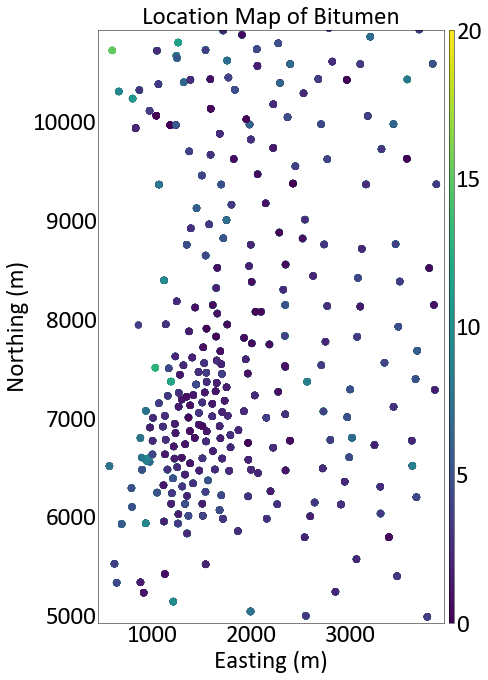

In [8]:
gs.set_style('pt25')

gs.locmap(datafl,var = 'Bitumen',orient='xy', sliceno= 9,slicetol=10, title = ('Location Map of Bitumen'), figsize=(10,10), vlim = (0,20))

plt.tight_layout()


In [9]:
## vtk file
outvtkfl = 'oilsands_out.vtk'
datafl.writefile(flname=outvtkfl, fltype='VTK')

### Declustering

In [10]:
declus = gs.Program('./packages/declus', getpar=True)

C:\Users\gamze\Desktop\SCI Paper 1-son - Major\Codes\Oilsands data example\tmpvl78g21y\declus.par has been copied to the clipboard


In [11]:
declusparstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21            - trimming limits
declus_ful.sum                  -file for summary output
declus_ful.out                  -file for output with data & weights
1   1                  -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  10.0  200               -number of cell sizes, min size, max size
20                           -number of origin offsets
"""
Data = gs.DataFile(flname='oilsands.dat', griddef = griddef, readfl=True)

declus.run(declusparstr.format(datafl = Data.flname,
                           xyzcol = Data.gscol(Data.xyz),
                           varcol = Data.gscol('Bitumen')))
declus_fl = gs.DataFile('declus_ful.out',griddef=griddef)

Calling:  ['./packages/declus', 'temp']

 DECLUS Version: 3.001

  data file = oilsands.dat                            
  columns =            2           3           4           5
  tmin,tmax =  -1.0000000E+21  1.0000000E+21
  summary file = declus_ful.sum                          
  output file = declus_ful.out                          
  anisotropy =    1.000000       1.000000    
  minmax flag =            0
  ncell min max =          100   10.00000       200.0000    
  offsets =           20
 

 There are     5808 data with:
   mean value            =      7.70885
   minimum and maximum   =      0.00000    18.42800
   size of data vol in X =   3308.09009
   size of data vol in Y =   5980.09961
   size of data vol in Z =    129.00000

   declustered mean      =      6.92631
   min and max weight    =      0.43017     4.32509
   equal weighting       =      1.00000


 DECLUS Version: 3.001 Finished



In [12]:
declus_fl

DataFile: declus_ful.out
Attributes:
x: 'East',  y: 'North',  z: 'Elevation',  wts: 'Declustering Weight',  
Variables:
'Drillhole Number', 'Bitumen', 'Fines', 'Chlorides', 'Facies Code'
Grid Definitions:
35 500.0 100.0 
60 5000.0 100.0 
15 145.0 10.0

In [13]:
declus_sum = gs.DataFile('declus_ful.sum') 
declus_sum.head()

,Cell Size,Declustered Mean
0,0.0,7.708850
1,10.0,7.390259
2,11.9,7.349320
3,13.8,7.268794
4,15.7,7.208991


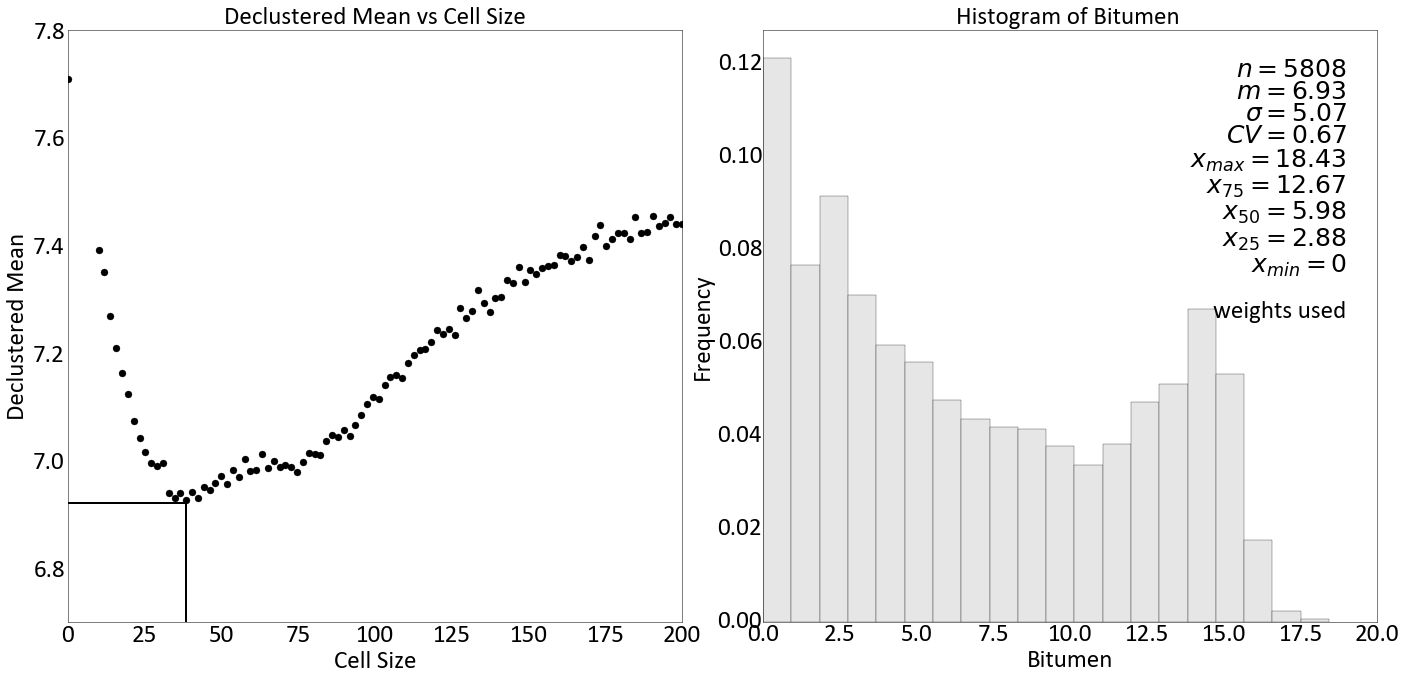

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gs.set_style('pt25')
ax1.scatter(declus_sum.data['Cell Size'], declus_sum.data['Declustered Mean'], c = 'Black')
ax1.set_title('Declustered Mean vs Cell Size')
ax1.set_xlabel('Cell Size')
ax1.set_ylabel('Declustered Mean')
ax1.set_xlim(0,200)
ax1.set_ylim(6.7, 7.8)
ax1.plot([38.5,38.5], [6.7, 6.92], 'k-', lw=2)
ax1.plot([0,38.5], [6.92,6.92], 'k-', lw=2)
plt.tight_layout()
gs.histplt(declus_fl,var='Bitumen',wt='Declustering Weight',title = 'Histogram of Bitumen ',bins=20,xlim=(0,20),ax=ax2)

plt.savefig('./Figures/Declustered data.png', bbox_inches = 'tight', dpi = 150)


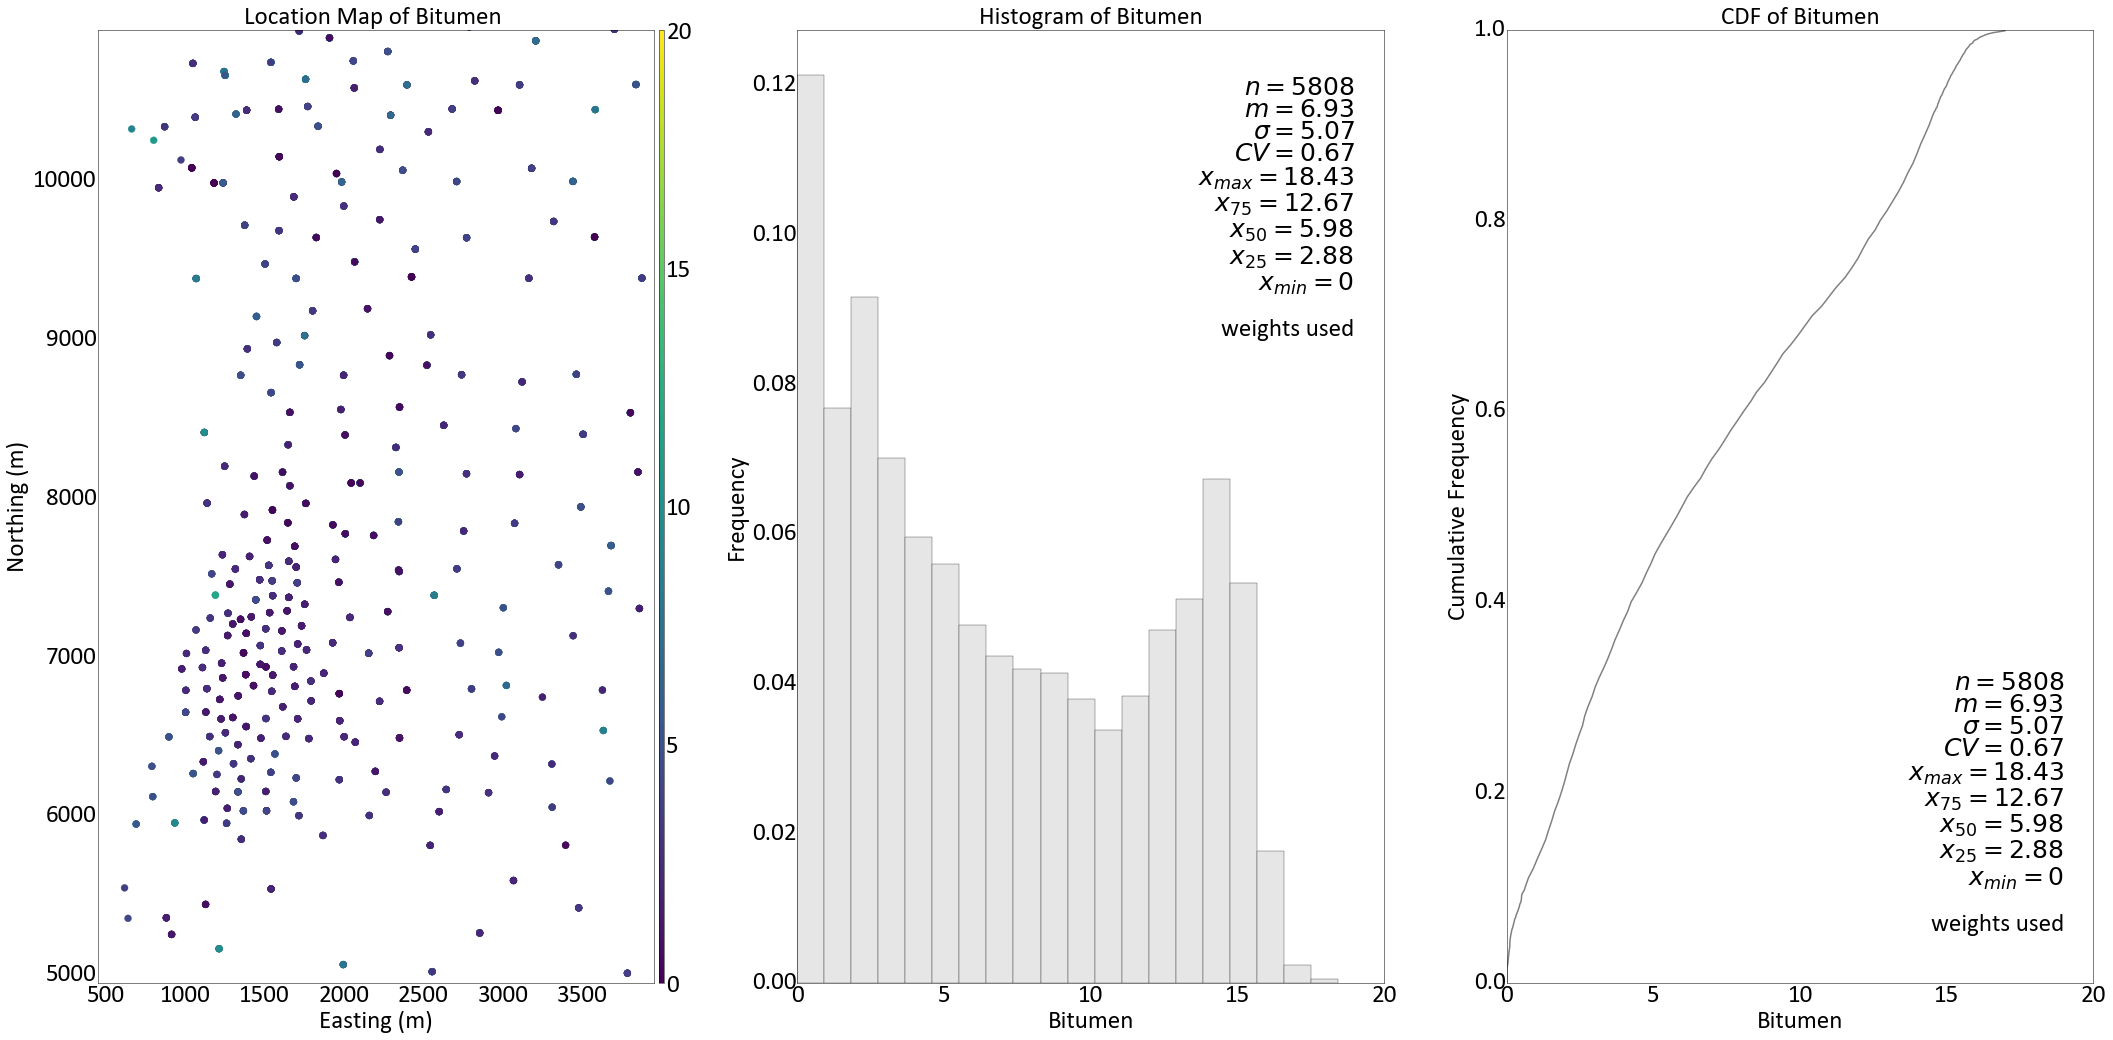

In [15]:
f, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(30, 15))
gs.locmap(datafl,var = 'Bitumen',orient='xy', sliceno= 20,slicetol=10, title = ('Location Map of Bitumen '), figsize=(10,10), vlim = (0,20),ax=ax1)
gs.histplt(declus_fl,var='Bitumen',wt='Declustering Weight',title = 'Histogram of Bitumen',bins=20,xlim=(0,20),ax=ax2)
gs.histplt(declus_fl,var='Bitumen',wt='Declustering Weight',xlim=(0,20),title = 'CDF of Bitumen',icdf=True,ax=ax3)
plt.tight_layout()
plt.savefig('./Figures/Data.png', bbox_inches = 'tight', dpi = 150)

## 2. ML Studies

### Data Split for CV

In [16]:
kfold = gs.Program('./packages/kfold', getpar=True)

C:\Users\gamze\Desktop\SCI Paper 1-son - Major\Codes\Oilsands data example\tmpjlfuoq9c\kfold.par has been copied to the clipboard


In [17]:
parstr = """                  Parameters for KFOLD
                  ********************

START OF PARAMETERS:
oilsands.dat                     -file with data
1   2 3 4    5               -   columns for DH,X,Y,Z,VR
-1.0     1.0e21              -   trimming limits
kfold.out                    -file for output
1                            -write Validation and Training files?
5                            -number of folds
1324978                      -random number seed
0.001  0.01  0.25   0.50              -weights: random, centroid, diff, same
"""
# kfold.run(parstr)
# kfold_fl = gs.DataFile('kfold.out',griddef=griddef)

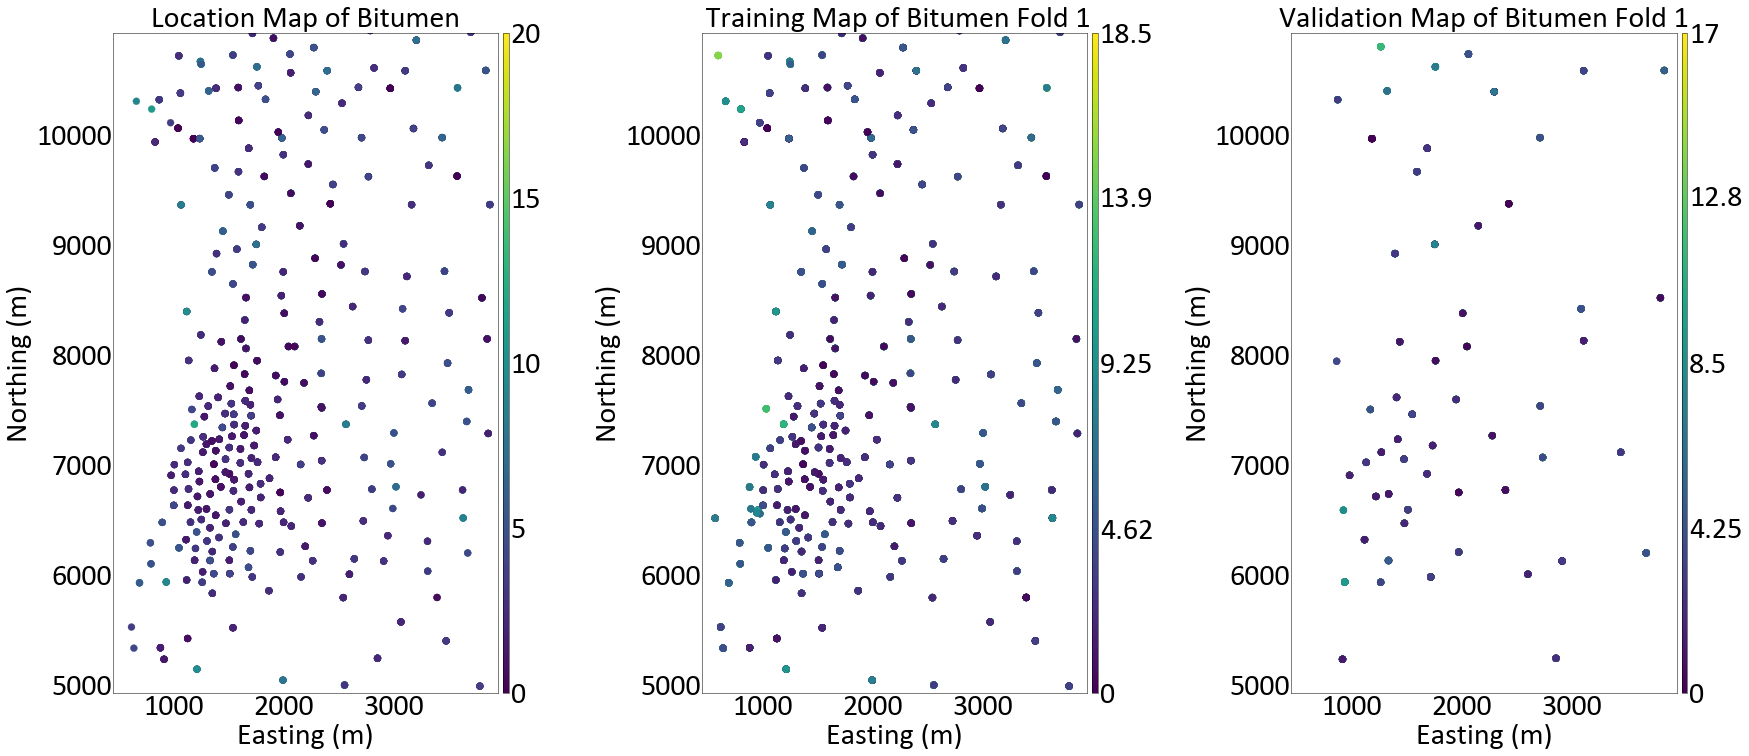

In [18]:
gs.set_style('pt30')
for Fold in range(1,2):
    Training = gs.DataFile(flname='Training0{}.dat'.format(Fold), griddef = griddef,
                       readfl=True)

    
    Validation = gs.DataFile(flname='Validation0{}.dat'.format(Fold), griddef = griddef,
                       readfl=True)
 
    f, axes = plt.subplots(1, 3, figsize=(25,25))
    
    gs.locmap(datafl,var = 'Bitumen',orient='xy', ax = axes[0],sliceno= 20,slicetol=10, title = 'Location Map of Bitumen'.format(Fold), vlim = (0,20))
#     gs.locmap(datafl,var = 'Bitumen',orient='xz', ax = axes[1,0],sliceno= 20,slicetol=10, title = 'Location Map XZ Fold {}'.format(Fold), vlim = (0,20))
    
    gs.locmap(Training,    var = 'Bitumen',orient = 'xy',ax = axes[1], title = ' Training Map of Bitumen Fold {}'.format(Fold),slicetol=29)
#     gs.locmap(Training,    var = 'Bitumen',orient = 'xz',ax = axes[1,1],title = ' Training Map XZ Fold {}'.format(Fold),slicetol=29)

    gs.locmap(Validation,  var = 'Bitumen',orient = 'xy',ax = axes[2], title = 'Validation Map of Bitumen Fold {}'.format(Fold),slicetol=29)
#     gs.locmap(Validation,  var = 'Bitumen',orient = 'xz',ax = axes[1,2], title = 'Validation Map XZ Fold {}'.format(Fold),slicetol=29)
    
    plt.tight_layout()
    plt.savefig('./Figures/Data{}.png'.format(Fold), bbox_inches = 'tight', dpi = 150)
    plt.show()

## 3. Machine Learning 

### Hyperparameter tuning

In [19]:
datatest = np.asarray(datafl.data)

#DH Training Data
min_val = np.min(datatest[:,3])
max_val = np.max(datatest[:,3])

print(min_val)
print(max_val)
X = datatest[:,0:3]/100
y = (datatest[:,3]-min_val)/(max_val-min_val)#Scaled
print(X.shape, y.shape)

146.5
275.5
(5808, 3) (5808,)


In [20]:
# # # Hyperparameter Tuning with Grid Search- All models except NN

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedKFold
# scoring = 'neg_mean_squared_error'
# seed = 7
# models_to_run = [SVR(kernel='rbf', gamma= 'scale'), 
#                  GradientBoostingRegressor(random_state=seed), 
#                  KNeighborsRegressor(), 
#                  RandomForestRegressor(random_state=seed), 
#                  BaggingRegressor(random_state=seed),
#                  ExtraTreesRegressor(random_state=seed),
#                  DecisionTreeRegressor(),
#                  AdaBoostRegressor()]

# models_param_grid = [{ # 1st param grid, corresponding to SVR
#                         'C': [10, 100, 1000],
#                         'epsilon': [0.01, 0.1, 1] 
#                     }, 
#                     { # 2nd param grid, corresponding to GBM
#                         'n_estimators': [300,500,700],
#                         'learning_rate':[0.01, 0.1, 0.2],
#                         'max_depth' : [3,4,6]
#                     },
#                     { # 3rd param grid, corresponding to KNN
#                             'n_neighbors': [11,13,15]
#                     },
#                     { # 4rd param grid, corresponding to RF
#                             'n_estimators': [300,500,700]
#                     },
#                     { # 5rd param grid, corresponding to BAG
#                             'n_estimators' : [300,500,700]
#                     },
#                     { # 7th param grid, corresponding to ET
#                             'n_estimators' : [100,200,300]
#                     },
#                     { # 8th param grid, corresponding to DT
#                             'max_depth' : [4,6,8,10]
#                     },
#                     { # 9th param grid, corresponding to ADA
#                             'n_estimators' : [100,200,300]
#                     }
#                     ]                            

# # define split of data
# kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

# # Tuning
# for i,model in enumerate(models_to_run):
#     grid = GridSearchCV(model, param_grid=models_param_grid[i], scoring=scoring, cv=kfold)
#     grid_result = grid.fit(X, y)
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [21]:
# Best: -0.025390 using {'C': 1000, 'epsilon': 0.1}
# Best: -0.024789 using {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
# Best: -0.026386 using {'n_neighbors': 15}
# Best: -0.025568 using {'n_estimators': 500}
# Best: -0.025568 using {'n_estimators': 500}
# Best: -0.025573 using {'n_estimators': 100}
# Best: -0.025156 using {'max_depth': 8}
# Best: -0.025273 using {'n_estimators': 300}

In [22]:
# #Tune the Number of Neurons in one Hidden Layer

# def wider_model(neurons=1):
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(neurons, input_dim=3, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0, epochs=200,batch_size=60)

# # define the grid search parameters
# neurons = [10,15,20,25]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [23]:
# Best: -0.026321 using {'neurons': 10}
# -0.026321 (0.001486) with: {'neurons': 10}
# -0.026778 (0.001681) with: {'neurons': 15}
# -0.026751 (0.001280) with: {'neurons': 20}
# -0.026452 (0.001535) with: {'neurons': 25}

In [24]:
# #Tune the Number of  Hidden Layers

# def wider_model(optimizer='adam', activation = 'sigmoid', hidden_layers=1):
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
    
# 	for i in range(hidden_layers):
# 		# Add one hidden layer
# 		model.add(Dense(10, activation=activation))

# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0, epochs=200,batch_size=60)
# hidden_layers =[2,3,4,5]

# param_grid = dict(hidden_layers=hidden_layers)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [25]:
# Best: -0.026361 using {'hidden_layers': 3}
# -0.026596 (0.001553) with: {'hidden_layers': 2}
# -0.026361 (0.001660) with: {'hidden_layers': 3}
# -0.026381 (0.001969) with: {'hidden_layers': 4}
# -0.026365 (0.001712) with: {'hidden_layers': 5}

In [26]:
# #Tune Batch Size and Number of Epochs

# # define the model
# def wider_model():
# 	# create model
# 	model = Sequential()
# 	model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(10, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(10, kernel_initializer='normal', activation='relu'))
# 	model.add(Dense(1, kernel_initializer='normal'))
# 	# Compile model
# 	model.compile(loss='mean_squared_error', optimizer='adam')
# 	return model

# # fix random seed for reproducibility
# seed = 7
# numpy.random.seed(seed)
# model6 = KerasRegressor(build_fn=wider_model, verbose=0)

# # define the grid search parameters
# batch_size = [10,20, 40, 60, 80, 100]
# epochs = [100,200,300,400,500]
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model6, param_grid=param_grid, n_jobs=-1, cv=kfold)
# grid_result = grid.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [27]:
# Best: -0.026316 using {'batch_size': 10, 'epochs': 300}

### Super Learner

In [28]:
# from sklearn.linear_model import LinearRegression
# seed=7

# data = np.asarray(datafl.data)
# min_val = np.min(data[:,4])
# max_val = np.max(data[:,4])
# print(min_val)
# print(max_val)

# #Prediction Grid
# x,Y,Z = griddef.gridcoord()
# X_all = np.hstack((x.reshape(len(x),1),Y.reshape(len(Y),1),Z.reshape(len(Z),1)))/100

# gs.write_gslib(pd.DataFrame(X_all,columns = ['X', 'Y', 'Z']),'./predictions/X_all.dat')

# for fold in range (5):
#     fold  += 1
#     print(fold)
#     pred_all = list()
#     pred_val = list()    
    
#     Training = gs.DataFile(flname='Training0{}.dat'.format(fold), griddef = griddef, readfl=True, tmin = -1e21)
#     datatest = np.asarray(Training.data)
#     X =  datatest[:,[1,2,3]]/100
#     y =  (datatest[:,4:5]- min_val) / (max_val-min_val)

#     Validation= gs.DataFile(flname='Validation0{}.dat'.format(fold), griddef = griddef, readfl=True,tmin = -1e21)
#     datatest = np.asarray(Validation.data)
#     X_val =  datatest[:,[1,2,3]]/100
#     y_val =  (datatest[:,4:5]- min_val) / (max_val-min_val) 

        
#     ###TRAINING

#     # define base model
#     def baseline_model():
#         # create model
#         model = Sequential()
#         model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
#         model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#         model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#         model.add(Dense(1, kernel_initializer='normal'))
#         # Compile model
#         model.compile(loss='mean_squared_error', optimizer='adam')
#         return model

#     # create a list of base-models
#     def get_models():
#         models = list()
#         models.append(SVR(C= 1000,epsilon = 0.1, kernel='rbf', gamma='scale'))
#         models.append(GradientBoostingRegressor(n_estimators = 500, max_depth = 4, learning_rate = 0.01))
#         models.append(KNeighborsRegressor(n_neighbors=15))
#         models.append(RandomForestRegressor(n_estimators=500))
#         models.append(BaggingRegressor(n_estimators=500))
#         models.append(KerasRegressor(build_fn=baseline_model, batch_size = 10, epoch=300, verbose=0))
#         models.append(ExtraTreesRegressor(n_estimators=100))
#         models.append(DecisionTreeRegressor(n_estimators=8))
#         models.append(AdaBoostRegressor(n_estimators=300))
#         return models

#     # collect out of fold predictions form k-fold cross validation

#     def get_out_of_fold_predictions(X, y, models):
#         meta_X, meta_y = list(), list()
#         # define split of data
#         kfold = KFold(n_splits=5, shuffle=True,random_state=seed)
#         # enumerate splits
#         fold_num= 0
#         for train_ix, test_ix in kfold.split(X):
#             fold_num += 1
#             fold_yhats = list()
#             # get data
#             train_X, test_X = X[train_ix], X[test_ix]
#             train_y, test_y = y[train_ix], y[test_ix]
#             meta_y.extend(test_y)
#             # fit and make predictions with each sub-model
#             for model in models:
#                 model.fit(train_X, train_y)
#                 yhat = model.predict(test_X)
#                 # store columns
#                 fold_yhats.append(yhat.reshape(len(yhat),1))
#             # store fold yhats as columns
#             meta_X.append(hstack(fold_yhats))      
#         return vstack(meta_X), asarray(meta_y)

#     # fit all base models on the training dataset
#     def fit_base_models(X, y, models):
#         for model in models:
#             model.fit(X, y)

#     # fit a meta model
#     def fit_meta_model(X, y):
#         model = LinearRegression()
#         model.fit(X, y)
#         return model

#     # make predictions with stacked model
#     def super_learner_predictions(X, models, meta_model):
#         meta_X = list()
#         for model in models:
#             yhat = model.predict(X)
#             meta_X.append(yhat.reshape(len(yhat),1))
#         meta_X = hstack(meta_X)
#         # predict
#         return meta_model.predict(meta_X)

#     # get models
#     models = get_models()

#     # get out of fold predictions
#     meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
#     print('Meta ', meta_X.shape, meta_y.shape)   

#     # fit base models
#     fit_base_models(X, y, models)

#     # fit the meta model
#     meta_model = fit_meta_model(meta_X, meta_y)
        
#     ###VALIDATION
#     y_val_pred = super_learner_predictions(X_val, models, meta_model)
#     print('Stacking Learner Validation: RMSE %.3f' % (sqrt(mean_squared_error(y_val, y_val_pred))))
#     print('Stacking Learner Validation: R2 %.3f' % (r2_score(y_val, y_val_pred)))
#     pred_val.append(y_val_pred.reshape(len(y_val_pred),1))
#     gs.write_gslib(pd.DataFrame(y_val_pred),'./predictions/pred_val{}.dat'.format(fold))
        
#     ###PREDICTION    
#     yhat_all = super_learner_predictions(X_all, models, meta_model)*(max_val-min_val)+min_val
#     pred_all.append(yhat_all.reshape(len(yhat_all),1))
#     gs.write_gslib(pd.DataFrame(yhat_all),'./predictions/pred_all{}.dat'.format(fold))
    

## 4. Variogram Calculation,  Modeling and Kriging for folds

In [29]:
varcalc = gs.Program('./packages/varcalc')
varmodel = gs.Program('./packages/varmodel')
kt3dn = gs.Program('./packages/kt3dn')
declus = gs.Program('./packages/declus') 

In [30]:
declusstr = """                  Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}         -file with data
{xyzcol}   {varcol}               -  columns for X, Y, Z, and variable
-1.0e21     1.0e21            - trimming limits
declus/declus_{fold}.sum                  -file for summary output
declus/declus_{fold}.out                  -file for output with data & weights
1   1                  -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
100  10.0  200               -number of cell sizes, min size, max size
20                           -number of origin offsets
"""
varcparstr = """                  Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}                         -   columns for X, Y, Z coordinates
1   {varcol}                            -   number of variables,column numbers (position used for tail,head variables below)
-99.0    1.0e21                  -   trimming limits
3                                 -number of directions
40 22.5 500 0.0 22.5 7 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 27  70  35                  -        number of lags,lag distance,lag tolerance
130 22.5 500 0.0 22.5 7 0.0    -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 27  70  35                  -        number of lags,lag distance,lag tolerance
0.  5  1000 -90 5 1000 0.0    -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 8 2 1                -        number of lags,lag distance,lag tolerance
./vargs/varcalc_{fold}.out                      -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1          200                       -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   ?                     -tail variable, head variable, variogram type (and cutoff/category), sill

"""
varmparstr = """                  Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
./vargs/varmodel_{fold}.out                 -file for modeled variogram points output
3                            -number of directions to model points along
  40 0.0  4000   0.5      -  azm, dip, npoints, point separation
  130 0.0  4000   0.5      -  azm, dip, npoints, point separation
  0.0  90.0  1000   0.5      -  azm, dip, npoints, point separation
2    0.07:0.08             -  nst, nugget effect
2    0.25  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
        400.0  300.0  25.0    -a_hmax, a_hmin, a_vert
2    0.67  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
      8000.0 4500.0  30.0    -a_hmax, a_hmin, a_vert
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc}                  -    experimental output file 1
3   1  2  3                    -      # of variograms (<=0 for all), variogram #s
1   1   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
./vargs/varmodel_{fold}.var              -  file to save fit variogram model
"""
kt3dnparstr = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}                            -file with data
0  {xyzcol} {varcol}  0             -  columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -  trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
2 3  4 5 0                      -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
./predictions/kt3dn_{fold}.out         -file for kriged output (see GSB note)
{griddef}
4   4   4                       -x,y and z block discretization
6    60    12    1               -min, max data for kriging,upper max for ASO,ASO incr
0      0                         -max per octant, max per drillhole (0-> not used)
4000.0  4000.0  4000.0           -maximum search radii
 0     0        0                 -angles for search ellipsoid
1                               -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
{mean} 0.6  0.8                  -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -  column number in gridded file
key_out.out                       -gridded file with keyout (see note)
0    1                           -  column (0 if no keyout) and value to keep
2    0.08                     -nst, nugget effect
2    0.25  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
        400.0  300.0  25.0    -a_hmax, a_hmin, a_vert
2    0.67  40.0   0.0   0.0    -it,cc,ang1,ang2,ang3
      8000.0 4500.0  30.0    -a_hmax, a_hmin, a_vert
"""

In [31]:
for fold in range(1,6):
    Traindat = gs.DataFile('Training0{}.dat'.format(fold),griddef=griddef)

    declus.run(declusstr.format(datafl = Traindat.flname,
                         xyzcol = Traindat.gscol(Traindat.xyz),
                         varcol = Traindat.gscol('Bitumen'),
                         fold = fold))
    
    mean = np.min(np.asarray(gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Declustered Mean']
                                    [gs.DataFile('declus/declus_{}.sum'.format(fold)).data['Cell Size']>0.0]))

    
    varcalc.run(varcparstr.format(datafl = Traindat.flname,
                             xyzcol = Traindat.gscol(Traindat.xyz),
                             varcol = Traindat.gscol('Bitumen'),
                             fold = fold))

    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))

   
    varmodel.run(varmparstr.format(varcalc = varcalcfl.flname,
                                 fold = fold))

    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))

    f = open("./vargs/varmodel_{}.var".format(fold), "r")
    varg = f.readlines()
    f.close()
    varg = ''.join(varg)
    
#     kt3dn.run(kt3dnparstr.format(datafl = Traindat.flname,
#                              xyzcol = Traindat.gscol(Traindat.xyz),
#                              varcol = Traindat.gscol('Bitumen'),
#                              griddef = griddef,
#                              varg = varg,
#                              fold = fold,
#                              mean = mean))

Calling:  ['./packages/declus', 'temp']

 DECLUS Version: 3.001

  data file = Training01.dat                          
  columns =            2           3           4           5
  tmin,tmax =  -1.0000000E+21  1.0000000E+21
  summary file = declus/declus_1.sum                     
  output file = declus/declus_1.out                     
  anisotropy =    1.000000       1.000000    
  minmax flag =            0
  ncell min max =          100   10.00000       200.0000    
  offsets =           20
 

 There are     4652 data with:
   mean value            =      7.69766
   minimum and maximum   =      0.00000    18.42800
   size of data vol in X =   3308.09009
   size of data vol in Y =   5980.09961
   size of data vol in Z =    129.00000

   declustered mean      =      6.91168
   min and max weight    =      0.43134     3.42864
   equal weighting       =      1.00000


 DECLUS Version: 3.001 Finished

Calling:  ['./packages/varcalc', 'temp']

varcalc version:  1.400

  data file: Trai

 There are     4642 data with:
   mean value            =      7.70039
   minimum and maximum   =      0.00000    18.42800
   size of data vol in X =   3308.09009
   size of data vol in Y =   5980.09961
   size of data vol in Z =    126.00000

   declustered mean      =      6.91683
   min and max weight    =      0.41417     4.57851
   equal weighting       =      1.00000


 DECLUS Version: 3.001 Finished

Calling:  ['./packages/varcalc', 'temp']

varcalc version:  1.400

  data file: Training03.dat
  x,y,z columns:            2           3           4
  number of variables:            1
  Variable columns:            5
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            3
  direction parameters:
 azm,azmtol,bandhorz   40.0000000000000        22.5000000000000     
   500.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   7.00000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol         

   size of data vol in Z =    129.00000

   declustered mean      =      6.93118
   min and max weight    =      0.63630     4.30391
   equal weighting       =      1.00000


 DECLUS Version: 3.001 Finished

Calling:  ['./packages/varcalc', 'temp']

varcalc version:  1.400

  data file: Training05.dat
  x,y,z columns:            2           3           4
  number of variables:            1
  Variable columns:            5
  tmin,tmax:   -99.0000000000000       1.000000000000000E+021
  number of directions:            3
  direction parameters:
 azm,azmtol,bandhorz   40.0000000000000        22.5000000000000     
   500.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   7.00000000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          27   70.0000000000000     
   35.0000000000000     
 azm,azmtol,bandhorz   130.000000000000        22.5000000000000     
   500.000000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.500000

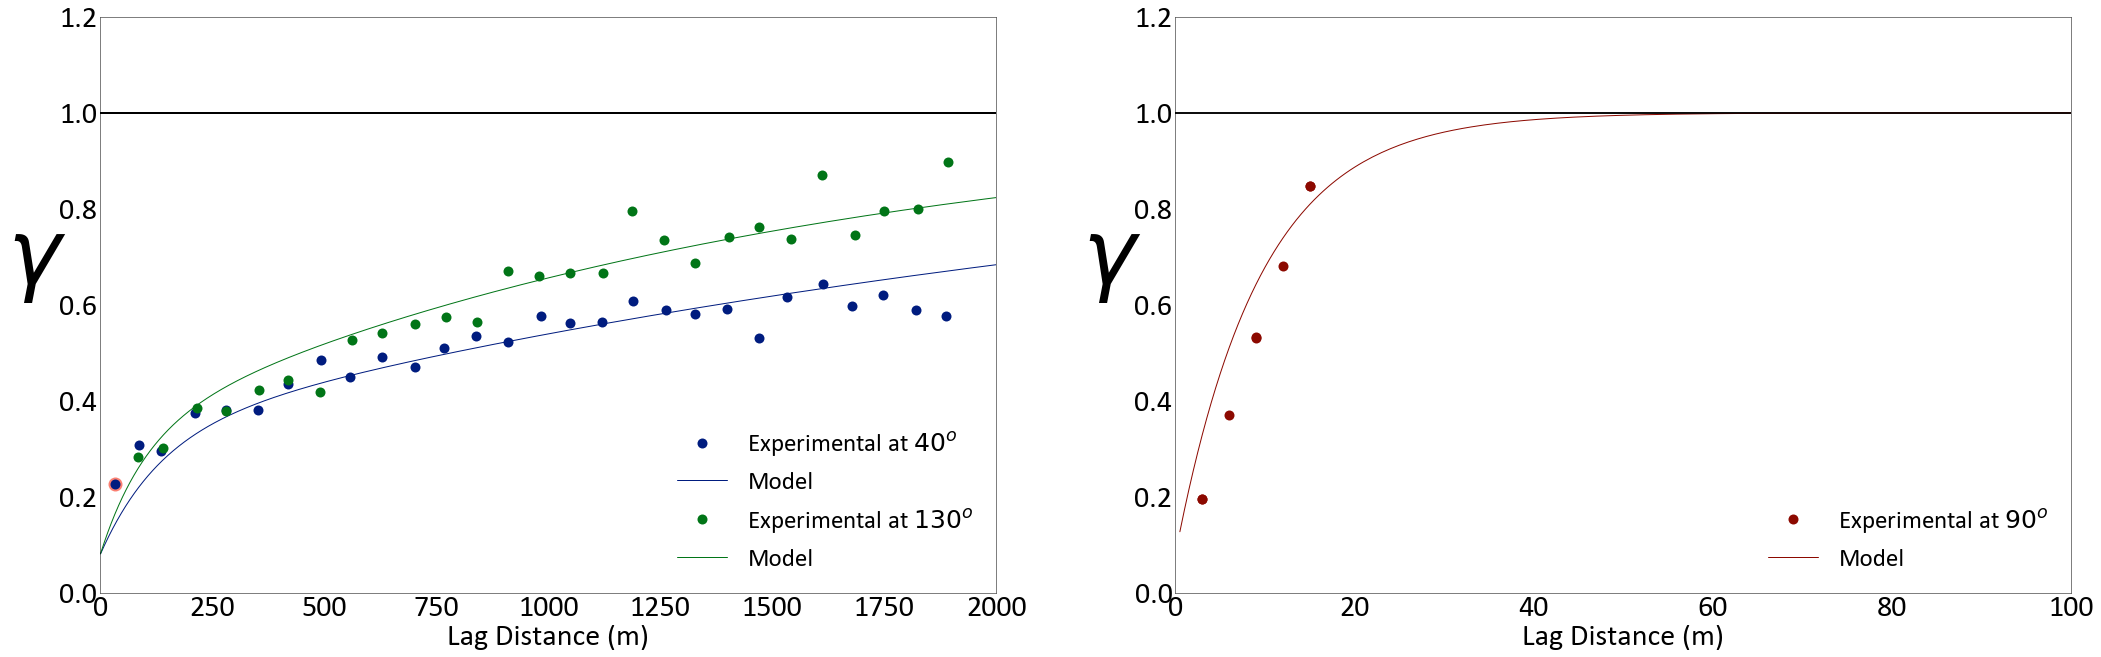

In [32]:
gs.set_style('pt30')
xlim = (0,2000)
for fold in range(1,2):
    f, (ax,ax2) = plt.subplots(1, 2, figsize=(15,10))
    varmodelfl = gs.DataFile('./vargs/varmodel_{}.out'.format(fold))
    varcalcfl = gs.DataFile('./vargs/varcalc_{}.out'.format(fold))
    
    colors = gs.get_palette('cat_dark', 3, cmap=False)
    
    ax1 = gs.varplt(varcalcfl.data,index = 1,ax =ax,color=colors[0] ,ms = 10,label= 'Experimental at $40^{o}$', xlim = xlim)
    ax1 = gs.varplt(varmodelfl,experimental=False,color=colors[0] ,index = 1,ax =ax, label= 'Model', xlim = xlim)

    ax1 = gs.varplt(varcalcfl.data,index = 2,ax =ax,color=colors[1] ,ms = 10, label= 'Experimental at $130^{o}$', xlim = xlim)
    ax1 = gs.varplt(varmodelfl,experimental=False,color=colors[1] ,ms = 10,index = 2,ax =ax, label= 'Model', xlim = xlim)

    ax2 = gs.varplt(varcalcfl.data,index = 3,ax =ax2,color=colors[2] ,ms = 10, label= 'Experimental at $90^{o}$',xlim=(0,100))
    ax2 = gs.varplt(varmodelfl,experimental=False,color=colors[2] ,ms = 10,index = 3,ax =ax2, label= 'Model',xlim=(0,100))
    ax.legend (loc = 4, fontsize=25)
    ax2.legend (loc = 4, fontsize=25)
    plt.tight_layout()    
    plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 1.95, top = 0.9, wspace = 0.2, hspace = 0.55)
    plt.savefig('./Figures/vargs_{}.png'.format(fold), bbox_inches = 'tight', dpi = 150)
    plt.show()



## 5. The combination of kriging and super learner

## Weights and Optimization

In [6]:
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

In [34]:
i=0
for Fold in range(1,6):
    i += 1
    testfile = gs.DataFile('Validation0{}.dat'.format(Fold))
#     testfile = gs.DataFile('oilsands.dat')
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(Fold),griddef=griddef)
    pltdat_ml = gs.DataFile('./predictions/pred_all{}.dat'.format(Fold),griddef=griddef)
    
    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['East'],y=testfile.data['North'],z=testfile.data['Elevation'])
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx>=0]
#################################################################################
###All
    columns =['Estimate']
    OK_all = pltdat_kt3dn.data['Estimate'].values
    OK_variance_all = pltdat_kt3dn.data['EstimationVariance'].values
    ML_all = pltdat_ml['0']

    minOK_val_all = np.min(OK_variance_all)
    maxOK_val_all = np.max(OK_variance_all)

    OK_st_variance_all= (OK_variance_all-minOK_val_all)/(maxOK_val_all-minOK_val_all)

    W_all  = hstack(OK_st_variance_all+ 0.0000000000000001)                                                     
    OK_all = hstack(OK_all)                                                     
    ML_all = hstack(ML_all)
##################################################################################
##Each fold
    OK = array(pltdat_kt3dn.data['Estimate'][idx].values).reshape((len(pltdat_kt3dn.data['Estimate'][idx]), 1))
    ML = array(pltdat_ml['0'][idx]).reshape((len(pltdat_ml['0'][idx]), 1))
    gs.write_gslib(pd.DataFrame(OK, columns=columns ),'./predictions/OK_{}.dat'.format(Fold))
    
    OK_variance = array(pltdat_kt3dn['EstimationVariance'][idx].values).reshape((len(pltdat_kt3dn['EstimationVariance'][idx].values), 1))
    gs.write_gslib(pd.DataFrame(OK_variance, columns =['EstimationVariance']),'./predictions/OK_var{}.dat'.format(Fold))
                   
    min_val = np.min(OK_variance)
    max_val = np.max(OK_variance)
#     print(min_val)
#     print(max_val)   
    
    OK_st_variance= (OK_variance-min_val)/(max_val-min_val)  
    gs.write_gslib(pd.DataFrame(OK_st_variance),'./predictions/OK_st_var{}.dat'.format(Fold))     

    W  = hstack(OK_st_variance+ 0.0000000000000001)
    OK = hstack(OK)
    ML = hstack(ML)

##################################################################################
##Optimisation
    
    def objective(weights):
        b0, b1 = weights[0], weights[1]
        for weight in zip(weights):
            final_prediction = W ** ((b0 + b1 * OK)) *ML+ (1-W+0.0000000000000001) ** ((b0 + b1 * OK)) * OK
        return sqrt(mean_squared_error(testfile.data['Bitumen'], final_prediction))

    starting_values = [0, 0]
    res = minimize(objective, starting_values, method='SLSQP', options={'disp': True, 'ftol':1e-100})

    print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
    print('Best Weights: {weights}'.format(weights=res['x']))
    
#     superlearner_val_opt = hstack(W ** ((res['x'][0]+res['x'][1]* OK)) * ML+
#                               (1-W) ** ((res['x'][0]+res['x'][1]* OK)) * OK)
#     gs.write_gslib(pd.DataFrame(superlearner_val_opt),'./predictions/superlearner_val_opt{}.dat'.format(Fold))


    superlearner_all_opt = hstack(W_all ** ((res['x'][0]+res['x'][1]* OK_all)) * ML_all+ 
                          (1-W_all+0.0000000000000001) ** ((res['x'][0]+res['x'][1] * OK_all)) * OK_all)
    
    gs.write_gslib(pd.DataFrame(superlearner_all_opt),'./predictions/superlearner_all_opt{}.dat'.format(Fold))
    
    

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1838727954351476
            Iterations: 18
            Function evaluations: 87
            Gradient evaluations: 18
Ensemble Score: 3.1838727954351476
Best Weights: [0.92439503 0.00136952]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3469987888174697
            Iterations: 14
            Function evaluations: 55
            Gradient evaluations: 14
Ensemble Score: 3.3469987888174697
Best Weights: [ 1.26227281 -0.02253365]


C:\Users\gamze\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:258: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.4346424590499156
            Iterations: 18
            Function evaluations: 80
            Gradient evaluations: 18
Ensemble Score: 3.4346424590499156
Best Weights: [0.96105682 0.00422378]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3969447278646774
            Iterations: 13
            Function evaluations: 63
            Gradient evaluations: 13
Ensemble Score: 3.3969447278646774
Best Weights: [0.93851896 0.00310002]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3355591229454142
            Iterations: 16
            Function evaluations: 73
            Gradient evaluations: 16
Ensemble Score: 3.3355591229454142
Best Weights: [0.84158498 0.01502943]


C:\Users\gamze\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:258: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


## 6. Comparision of Kriging and Super Learner

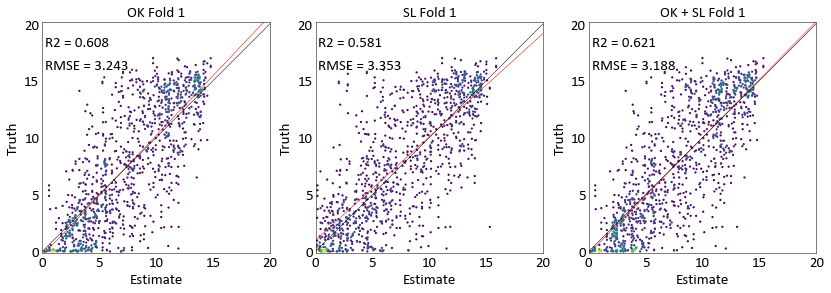

msre OK: 2.030
msre SL: 2.170
msre OK+SL: 1.962
mean error OK: -0.057
mean error SL: -0.306
mean error OK+SL: 0.043
mean  OK: 7.697
mean  SL: 7.448
mean  OK+SL: 7.796
sd  OK: 3.839
sd  SL: 4.382
sd  OK+SL: 4.000


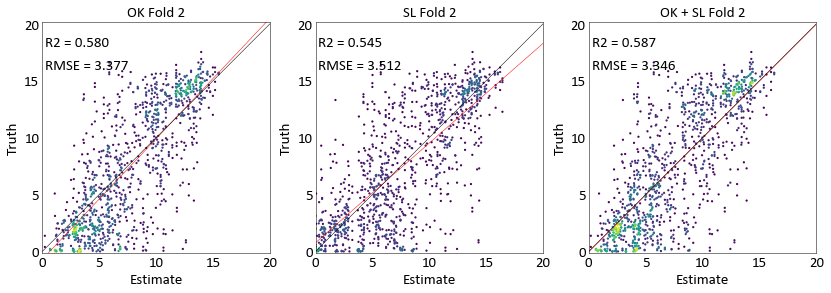

msre OK: 2.190
msre SL: 2.368
msre OK+SL: 2.149
mean error OK: 0.237
mean error SL: 0.185
mean error OK+SL: 0.047
mean  OK: 7.691
mean  SL: 7.639
mean  OK+SL: 7.501
sd  OK: 3.758
sd  SL: 4.440
sd  OK+SL: 3.991


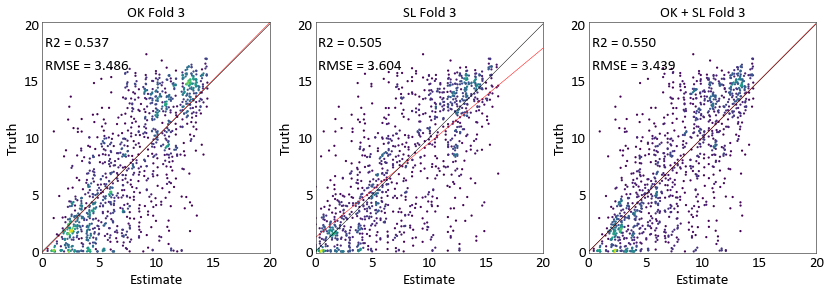

msre OK: 2.371
msre SL: 2.535
msre OK+SL: 2.308
mean error OK: 0.007
mean error SL: 0.082
mean error OK+SL: -0.013
mean  OK: 7.707
mean  SL: 7.782
mean  OK+SL: 7.687
sd  OK: 3.716
sd  SL: 4.470
sd  OK+SL: 3.783


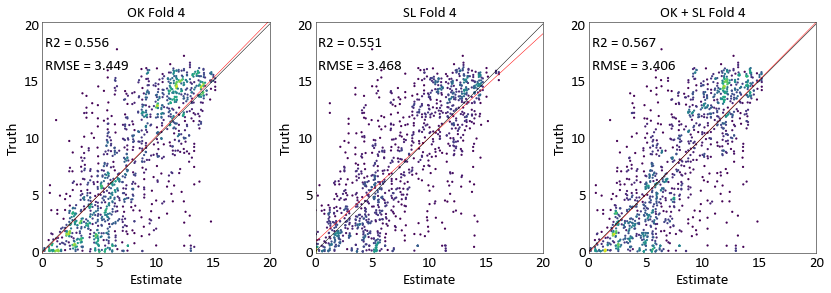

msre OK: 2.298
msre SL: 2.324
msre OK+SL: 2.241
mean error OK: -0.059
mean error SL: -0.195
mean error OK+SL: 0.007
mean  OK: 7.788
mean  SL: 7.653
mean  OK+SL: 7.854
sd  OK: 3.779
sd  SL: 4.226
sd  OK+SL: 3.850


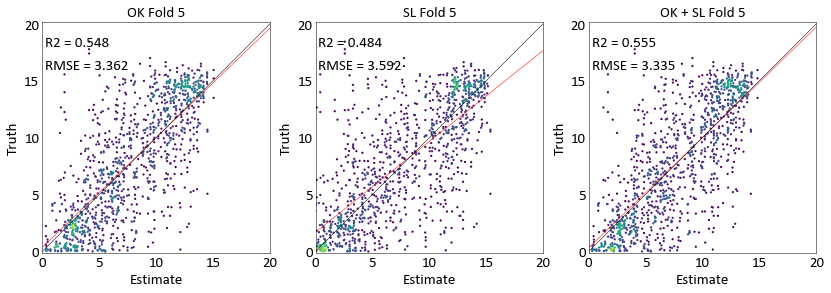

msre OK: 2.259
msre SL: 2.580
msre OK+SL: 2.223
mean error OK: -0.082
mean error SL: -0.150
mean error OK+SL: -0.082
mean  OK: 7.675
mean  SL: 7.607
mean  OK+SL: 7.674
sd  OK: 3.852
sd  SL: 4.510
sd  OK+SL: 3.843


In [7]:
from sklearn.metrics import make_scorer
from os import path

slinceno=9
vlim =(0,19)
pltlim = (0,20)
i=0

gs.set_style('pt15')

krig_av = np.zeros(shape=(31500,1))
ML_av = np.zeros(shape=(31500,1))
SL_av = np.zeros(shape=(31500,1))

idx_kFold = []
test_stack = []

KRG_R2 = 0
KRG_RMSE = 0
KRG_ME = 0
KRG_MSRE = 0

ML_R2 = 0
ML_RMSE = 0
ML_ME = 0
ML_MSRE = 0

SL_R2 = 0
SL_RMSE =0
SL_ME = 0
SL_MSRE = 0

stat_blk = []

from sklearn.metrics import make_scorer

# Calculate mean error
def mean_error( predicted, actual):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error)
	mean_error = sum_error / float(len(actual))
	return mean_error

def msre(predicted, actual):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return mean_error/ numpy.std(actual)
    
    
for Fold in range(0,5):
    Fold +=1
    i += 1
    testfile = gs.DataFile('Validation0{}.dat'.format(Fold))
    pltdat_kt3dn = gs.DataFile('./predictions/kt3dn_{}.out'.format(Fold),griddef=griddef)
    pltdat_ml = gs.DataFile('./predictions/pred_all{}.dat'.format(Fold),griddef=griddef)
    combined = gs.DataFile('./predictions/superlearner_all_opt{}.dat'.format(Fold),griddef=griddef)
    
    declus = gs.DataFile('./declus/declus_{}.out'.format(Fold)) 

    pltdat_ml.data['0'][pltdat_ml.data['0'] < 0] = 0
    combined.data['0'][combined.data['0'] < 0] = 0
    
    pltdat_ml = gaussian_filter(pltdat_ml.data['0'],sigma = 0)
    combined = gaussian_filter(combined.data['0'],sigma = 0)    

    
    krig_av = krig_av +  pltdat_kt3dn.data['Estimate'].values.reshape(len(pltdat_kt3dn.data['Estimate']),1)
    ML_av = ML_av + pltdat_ml.reshape(len(pltdat_kt3dn.data['Estimate']),1)
    SL_av = SL_av + combined.reshape(len(pltdat_kt3dn.data['Estimate']),1)

    idx,ingrid = griddef.coord_to_index1d(x=testfile.data['East'],y=testfile.data['North'],z=testfile.data['Elevation'])
    idx_kFold[1163*(i-1):1163*i] = idx
    test_stack[1163*(i-1):1163*i] = testfile.data['Bitumen']
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx>=0]
    
    ###############################################################################################################  
    
#     f, axes = plt.subplots(1, 3, figsize=(30, 20))
#     ax2 = gs.pixelplt(pltdat_kt3dn,ax = axes[0],
#                 title = 'OK Prediction Fold {}'.format(Fold),vlim=vlim, sliceno=slinceno)
#     #ax2 = gs.locmap(datafl, ax=ax2,sliceno=slinceno, var = 'Bitumen' , vlim=vlim,title = 'OK Prediction')

#     ax3 = gs.pixelplt(pltdat_ml,griddef=griddef,ax = axes[1],
#                 title = 'SL Prediction Fold {}'.format(Fold),vlim=vlim, sliceno=slinceno)
#     #ax3 = gs.locmap(datafl, ax=ax3,sliceno=slinceno, var = 'Bitumen' , vlim=vlim,title = 'ML prediction XY ensemble')
    
#     ax4 = gs.pixelplt(combined,griddef=griddef,ax = axes[2],
#                 title = 'OK + SL Prediction Fold {}'.format(Fold),vlim=vlim, sliceno=slinceno)
#     #ax4 = gs.locmap(datafl, ax=ax3,sliceno=slinceno, var = 'Bitumen' , vlim=vlim,title = 'ML prediction XY ensemble')
    
#     plt.tight_layout()
#     plt.savefig('./Figures/pixlpltxy_{}.png'.format(Fold), bbox_inches = 'tight', dpi = 150)
#     plt.show()
    
    ################################################################################################################     
    
    f, axes = plt.subplots(1, 3, figsize=(10,4))

    ax2 = gs.scatxval(pltdat_kt3dn.data['Estimate'][idx].values,testfile.data['Bitumen'],xlabel='Estimate', ylabel='Truth',
                      ms=5,
            title = 'OK Fold {}'.format(Fold),dens=True,ax = axes[0],vlim=pltlim, stat_blk = stat_blk)
    ax2.text(0.25,18,'R2 = {0:.3f}'.format(r2_score(testfile.data['Bitumen'],pltdat_kt3dn.data['Estimate'][idx].values)))
    ax2.text(0.25,16,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(testfile.data['Bitumen'],
                                                                           pltdat_kt3dn.data['Estimate'][idx].values))))

    ax3 = gs.scatxval(pltdat_ml[idx],testfile.data['Bitumen'],xlabel='Estimate', ylabel='Truth',ms=5,
            title = 'SL Fold {}'.format(Fold),dens=True,ax = axes[1],vlim=pltlim,stat_blk = stat_blk)
    ax3.text(0.25,18,'R2 = {0:.3f}'.format(r2_score(testfile.data['Bitumen'],pltdat_ml[idx])))
    ax3.text(0.25,16,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(testfile.data['Bitumen'],pltdat_ml[idx]))))

    ax4 = gs.scatxval(combined[idx],testfile.data['Bitumen'],xlabel='Estimate', ylabel='Truth',ms=5,
            title = 'OK + SL Fold {}'.format(Fold),dens=True,ax = axes[2],vlim=pltlim,stat_blk = stat_blk)
    ax4.text(0.25,18,'R2 = {0:.3f}'.format(r2_score(testfile.data['Bitumen'],combined[idx])))
    ax4.text(0.25,16,'RMSE = {0:.3f}'.format(sqrt(mean_squared_error(testfile.data['Bitumen'],combined[idx]))))

    plt.subplots_adjust (left = 0.125, bottom = 0.1, right = 1.2, top = 0.9, wspace = 0.2, hspace = 0.2)
    
    plt.savefig('./Figures/datarep_{}.jpg'.format(Fold), bbox_inches = 'tight', dpi = 150)

    plt.show()
    
    ################################################################################################################ 
    
#     f, axes = plt.subplots(1, 3, figsize=(30, 10))
#     ax2 = gs.histpltsim(pltdat_kt3dn.data['Estimate'],declus.data['Bitumen'],refwt = declus.data['Declustering Weight'],
#                         title = 'OK Histrogram Reprd Fold {}'.format(Fold),lw=5,ax=axes[0],griddef=griddef,nreal=1)


#     ax3 = gs.histpltsim(pltdat_ml,declus.data['Bitumen'],refwt = declus.data['Declustering Weight'],
#                         title = 'SL Histrogram Reprd Fold {}'.format(Fold),lw=5,ax=axes[1],griddef=griddef,nreal=1)
    
#     ax4 = gs.histpltsim(combined,declus.data['Bitumen'],refwt = declus.data['Declustering Weight'],
#                         title = 'OK + SL Histrogram Reprd Fold {}'.format(Fold),lw=5,ax=axes[2],griddef=griddef,nreal=1)
    
#     plt.savefig('./Figures/histplt_{}.png'.format(Fold), bbox_inches = 'tight', dpi = 150)
#     plt.show()
    
    ################################################################################################################ 

    KRG_R2 = KRG_R2 + r2_score(testfile.data['Bitumen'],pltdat_kt3dn.data['Estimate'][idx].values)
    KRG_RMSE = KRG_RMSE + mean_squared_error(testfile.data['Bitumen'],pltdat_kt3dn.data['Estimate'][idx].values)
    KRG_MSRE = KRG_MSRE + msre(pltdat_kt3dn.data['Estimate'][idx].values,np.asarray(testfile.data['Bitumen']))
    KRG_ME = KRG_ME + mean_error(pltdat_kt3dn.data['Estimate'][idx].values,np.asarray(testfile.data['Bitumen'])) 
    
    ML_R2 = ML_R2 + r2_score(testfile.data['Bitumen'],pltdat_ml[idx])           
    ML_RMSE = ML_RMSE + mean_squared_error(testfile.data['Bitumen'],pltdat_ml[idx]) 
    ML_MSRE = ML_MSRE + msre(pltdat_ml[idx],np.asarray(testfile.data['Bitumen']))    
    ML_ME = ML_ME + mean_error(pltdat_ml[idx],np.asarray(testfile.data['Bitumen']))

    SL_R2 = SL_R2 + r2_score(testfile.data['Bitumen'],combined[idx])           
    SL_RMSE = SL_RMSE + mean_squared_error(testfile.data['Bitumen'],combined[idx]) 
    SL_MSRE = SL_MSRE + msre(combined[idx],np.asarray(testfile.data['Bitumen']))   
    SL_ME = SL_ME + mean_error(combined[idx],np.asarray(testfile.data['Bitumen']))

    
    print('msre OK: %.3f' % msre(pltdat_kt3dn.data['Estimate'][idx].values,np.asarray(testfile.data['Bitumen'])))
    print('msre SL: %.3f' % msre(pltdat_ml[idx],np.asarray(testfile.data['Bitumen'])) )
    print('msre OK+SL: %.3f' % msre(combined[idx],np.asarray(testfile.data['Bitumen'])))
    
    print('mean error OK: %.3f' % mean_error(pltdat_kt3dn.data['Estimate'][idx].values,np.asarray(testfile.data['Bitumen'])))
    print('mean error SL: %.3f' % mean_error(pltdat_ml[idx],np.asarray(testfile.data['Bitumen'])))
    # print('mean error OK+SL: %.3f' % meanerrorCombined)
    print('mean error OK+SL: %.3f' % mean_error(combined[idx],np.asarray(testfile.data['Bitumen'])))

    print('mean  OK: %.3f' % np.mean(pltdat_kt3dn.data['Estimate'][idx].values))
    print('mean  SL: %.3f' % np.mean(pltdat_ml[idx]))
    print('mean  OK+SL: %.3f' % np.mean(combined[idx]))
    
    print('sd  OK: %.3f' % np.std(pltdat_kt3dn.data['Estimate'][idx].values))
    print('sd  SL: %.3f' % np.std(pltdat_ml[idx]))
    print('sd  OK+SL: %.3f' % np.std(combined[idx]))

# ################################################################################################################   
krig_av = pd.DataFrame((krig_av/i),columns = ['Estimate'])
ML_av = pd.DataFrame((ML_av/i),columns = ['0'])
SL_av = pd.DataFrame((SL_av/i),columns = ['0'])

test_stack = pd.DataFrame((test_stack),columns = ['Bitumen'])
idx_kFold = pd.DataFrame((idx_kFold),columns = ['0'])

test_stack = test_stack['Bitumen'][idx_kFold['0'] >= 0]
idx_kFold = idx_kFold['0'][idx_kFold['0'] >= 0]

# ############################################################################################################

# f, axes = plt.subplots(1, 3, figsize=(30,20))

# ax2 = gs.pixelplt(krig_av['Estimate'],ax = axes[0],griddef=griddef,
#             title = 'OK Prediction Overall',vlim=vlim, sliceno=slinceno)
# #ax2 = gs.locmap(datafl, ax=ax2,sliceno=slinceno, var = 'Bitumen' , vlim=vlim,title = 'OK Prediction')

# ax3 = gs.pixelplt(ML_av['0'],griddef=griddef,ax = axes[1],
#             title = 'SL Prediction Overall',vlim=vlim, sliceno=slinceno)
# #ax3 = gs.locmap(datafl, ax=ax3,sliceno=slinceno, var = 'Bitumen' , vlim=vlim,title = 'ML prediction XY ensemble')

# ax4 = gs.pixelplt(SL_av['0'],griddef=griddef,ax = axes[2],
#             title = 'OK + SL Prediction Overall',vlim=vlim, sliceno=slinceno)
# #ax4 = gs.locmap(datafl, ax=ax4,sliceno=slinceno, var = 'Bitumen' , vlim=vlim,title = 'ML prediction XY ensemble')

# plt.tight_layout()
# plt.savefig('./Figures/pixlpltxy_Overall.png', bbox_inches = 'tight', dpi = 150)
# plt.show()

# ################################################################################################################ 

# # f, axes = plt.subplots(1, 3, figsize=(30,10))
# # ax2 = gs.histpltsim(krig_av['Estimate'],declus.data['Bitumen'],refwt = declus.data['Declustering Weight'],lw=5,ax=axes[0],
# #                     griddef=griddef,nreal=1,title = 'OK Histrogram Reproduction Overall', stat_blk=False)


# # ax3 = gs.histpltsim(ML_av['0'],declus.data['Bitumen'],refwt = declus.data['Declustering Weight'],lw=5,ax=axes[1],
# #                     griddef=griddef,nreal=1,title = 'SL Histrogram Reproduction Overall',stat_blk=False)

# # ax4 = gs.histpltsim(SL_av['0'],declus.data['Bitumen'],refwt = declus.data['Declustering Weight'],lw=5,ax=axes[2],
# #                     griddef=griddef,nreal=1,title = 'OK + SL Histrogram Reproduction Overall', stat_blk=False)
# # plt.tight_layout()
# # plt.savefig('./Figures/histplt_Overall.png', bbox_inches = 'tight', dpi = 150)
# # plt.show()

# ################################################################################################################     
# print('The Overall R2 of the KRIG is {}'.format(round(KRG_R2/i,3)))
# print('The Overall R2 of the SL is {}'.format(round(ML_R2/i,3)))                
# print('The Overall R2 of the OK+SL is {}'.format(round(SL_R2/i,3))) 

# print('The Overall RMSE of the KRIG is {}'.format(round(np.sqrt(KRG_RMSE/i),3)))
# print('The Overall RMSE of the SL is {}'.format(round(np.sqrt(ML_RMSE/i),3)))
# print('The Overall RMSE of the OK+SL is {}'.format(round(np.sqrt(SL_RMSE/i),3)))

# print('The Overall MSRE of the KRIG is {}'.format(KRG_MSRE/i))
# print('The Overall MSRE of the SL is {}'.format(ML_MSRE/i))
# print('The Overall MSRE of the OK+SL is {}'.format(SL_MSRE/i))

# print('The Overall ME of the KRIG is {}'.format(KRG_ME/i))
# print('The Overall ME of the SL is {}'.format(ML_ME/i))
# print('The Overall ME of the OK+SL is {}'.format(SL_ME/i))


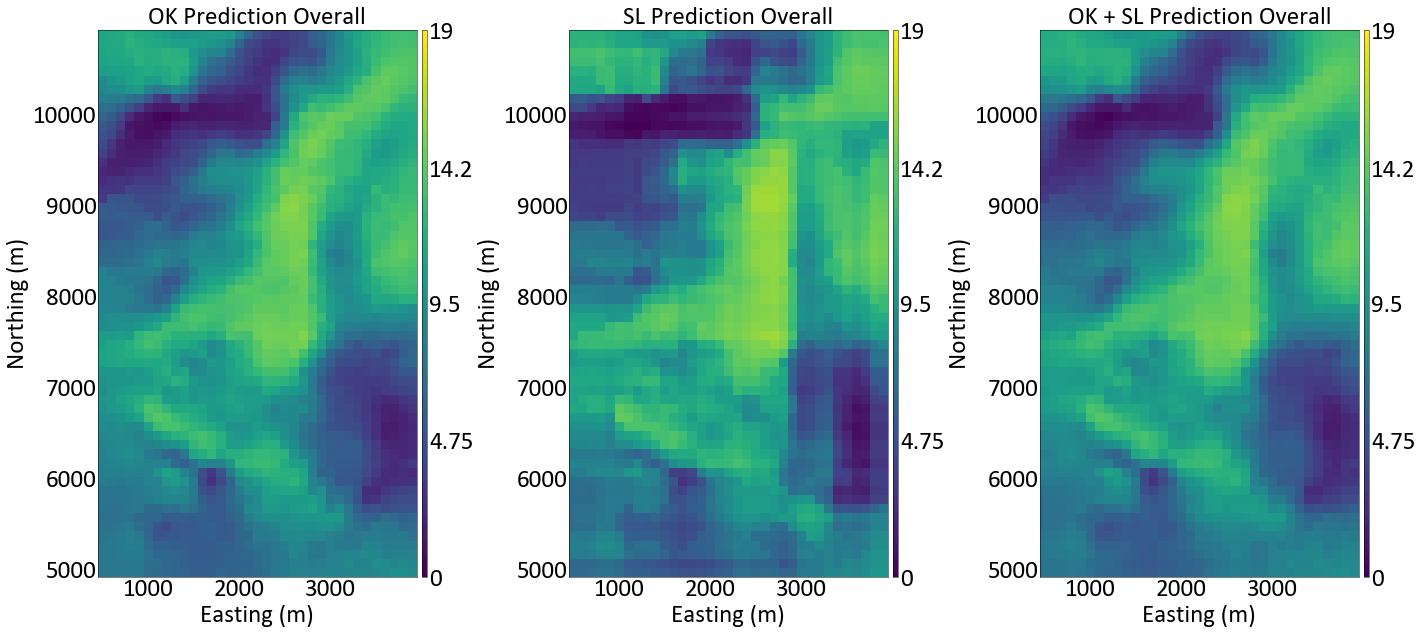

In [9]:
gs.set_style('pt25')
sliceno = 8
############################################################################################################

gridsize2 = (1,3)

fig = plt.figure(figsize = (20,20))
ax1 = plt.subplot2grid(gridsize2,(0,0)) 
ax2 = plt.subplot2grid(gridsize2,(0,1))
ax3 = plt.subplot2grid(gridsize2,(0,2))


gs.pixelplt(krig_av['Estimate'],orient = 'xy',ax = ax1,griddef=griddef,
            title = 'OK Prediction Overall',vlim=vlim, sliceno=slinceno)

gs.pixelplt(ML_av['0'],orient = 'xy',griddef=griddef,ax = ax2,
            title = 'SL Prediction Overall',vlim=vlim, sliceno=slinceno)

gs.pixelplt(SL_av['0'],orient = 'xy',griddef=griddef,ax = ax3,
            title = 'OK + SL Prediction Overall',vlim=vlim, sliceno=slinceno)


plt.subplots_adjust (left = 0.1, bottom = 0.125, right = 1.6, top = 0.8, wspace = 0.3, hspace = 0.12)

plt.tight_layout()
plt.savefig('./Figures/pixlpltxy_xy_Overall.png', bbox_inches = 'tight', dpi = 150)
plt.show()

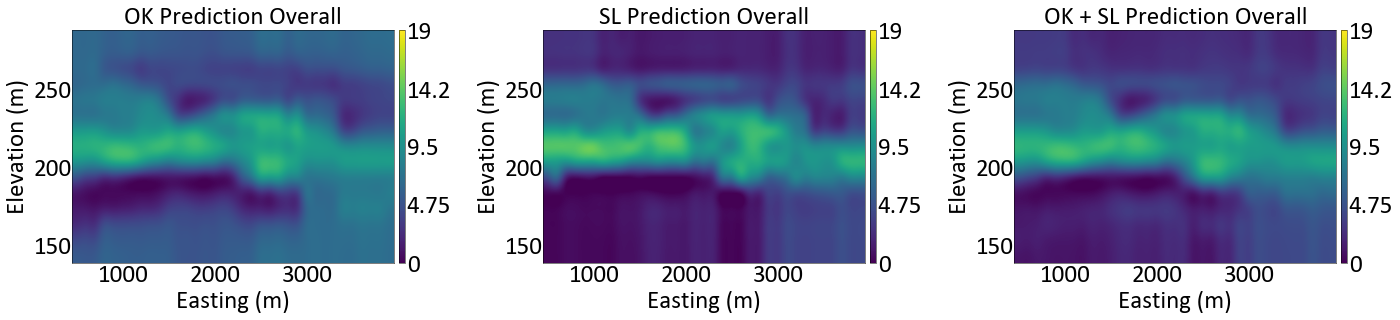

In [64]:
gs.set_style('pt25')
sliceno = 8
############################################################################################################

gridsize2 = (1,3)

fig = plt.figure(figsize = (20,5))
ax1 = plt.subplot2grid(gridsize2,(0,0)) 
ax2 = plt.subplot2grid(gridsize2,(0,1))
ax3 = plt.subplot2grid(gridsize2,(0,2))


gs.pixelplt(krig_av['Estimate'],orient = 'xz',ax = ax1,griddef=griddef,
            title = 'OK Prediction Overall',vlim=vlim, sliceno=slinceno)

gs.pixelplt(ML_av['0'],orient = 'xz',griddef=griddef,ax = ax2,
            title = 'SL Prediction Overall',vlim=vlim, sliceno=slinceno)

gs.pixelplt(SL_av['0'],orient = 'xz',griddef=griddef,ax = ax3,
            title = 'OK + SL Prediction Overall',vlim=vlim, sliceno=slinceno)

plt.subplots_adjust (left = 0.1, bottom = 0.125, right = 1.6, top = 0.8, wspace = 0.2, hspace = 0.12)

plt.tight_layout()
plt.savefig('./Figures/pixlpltxy_xz_Overall.png', bbox_inches = 'tight', dpi = 150)
plt.show()